In [ ]:
!cp drive/MyDrive/dataset_crochets_filter.zip .

In [ ]:
!unzip dataset_crochets_filter.zip

In [ ]:
!mkdir datasets
!mkdir datasets/crochets
!mkdir datasets/no-crochets

In [ ]:
import shutil
import os
carpeta_fuente = './dataset_crochets_no-crochets/crochets'
carpeta_destino = './datasets/crochets'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 6321:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [ ]:
carpeta_fuente = './dataset_crochets_no-crochets/no-crochets'
carpeta_destino = './datasets/no-crochets'

imagenes = os.listdir(carpeta_fuente)

for i, nombreimg in enumerate(imagenes):
  if i < 6321:
    #Copia de la carpeta fuente a la destino
    shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)

In [ ]:
!rm -r dataset_crochets_no-crochets/
!mv datasets/ dataset/

In [ ]:
!ls 'dataset/no-crochets' | wc -l
!ls 'dataset/crochets' | wc -l

6321
6321


In [ ]:
model_checkpoint = "google/vit-base-patch16-224"
batch_size = 32

In [ ]:
!pip install -q datasets transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./dataset")

Resolving data files:   0%|          | 0/18963 [00:00<?, ?it/s]

In [ ]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-5-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 18963
    })
})

In [ ]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=255x255>,
 'label': 0}

In [ ]:
dataset["train"].features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['crochets', 'no-crochets', 'others'], id=None)}

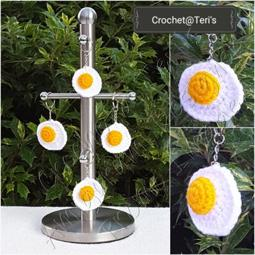

In [ ]:
example['image']

In [ ]:
example['label']

0

In [ ]:
dataset["train"].features["label"]

ClassLabel(names=['crochets', 'no-crochets', 'others'], id=None)

In [ ]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[0]

'crochets'

In [ ]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [ ]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [ ]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=255x255>,
 'label': 0,
 'pixel_values': tensor([[[ 0.9216,  0.9059,  0.9059,  ..., -0.3961, -0.3647, -0.2941],
          [ 0.8588,  0.8588,  0.8745,  ..., -0.3098, -0.2784, -0.2314],
          [ 0.8275,  0.8196,  0.8667,  ..., -0.2078, -0.2157, -0.2000],
          ...,
          [ 0.0118, -0.0431, -0.1294,  ..., -0.2706, -0.1137, -0.1451],
          [-0.0431,  0.0118, -0.0118,  ..., -0.2549, -0.0902, -0.0431],
          [-0.0118,  0.0824,  0.0667,  ..., -0.1294, -0.1294, -0.0588]],
 
         [[ 0.8275,  0.8196,  0.8039,  ..., -0.6627, -0.7412, -0.7255],
          [ 0.7647,  0.7647,  0.7725,  ..., -0.6627, -0.7490, -0.7490],
          [ 0.7333,  0.7255,  0.7647,  ..., -0.6314, -0.7569, -0.7725],
          ...,
          [-0.5294, -0.5843, -0.6706,  ..., -0.7725, -0.6392, -0.6706],
          [-0.5843, -0.5294, -0.5608,  ..., -0.7647, -0.6157, -0.5686],
          [-0.5608, -0.4667, -0.4824,  ..., -0.6549, -0.6627, -0.5922]]

In [ ]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install accelerate -U

In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install -U accelerate
!pip install -U transformers

In [ ]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-crochets-clothes-classification",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [ ]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [ ]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
0,0.037000,0.025993,0.991038
2,0.016700,0.016844,0.995783


events.out.tfevents.1708565382.e0eba228dbb5.9867.0:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

***** train metrics *****
  epoch                    =         2.99
  total_flos               = 3682725771GF
  train_loss               =       0.0841
  train_runtime            =   0:08:44.04
  train_samples_per_second =       97.698
  train_steps_per_second   =        0.761


In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       2.99
  eval_accuracy           =     0.9958
  eval_loss               =     0.0168
  eval_runtime            = 0:00:08.82
  eval_samples_per_second =    214.848
  eval_steps_per_second   =      6.795


In [ ]:
trainer.push_to_hub()

events.out.tfevents.1708565952.e0eba228dbb5.9867.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Nick6154-dev/vit-base-patch16-224-crochets-clothes-classification/commit/90c0ee00a07aaca168ec4980bd790ebe90d4eda7', commit_message='End of training', commit_description='', oid='90c0ee00a07aaca168ec4980bd790ebe90d4eda7', pr_url=None, pr_revision=None, pr_num=None)